In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from scipy.spatial.distance import cdist

In [2]:
def plot_result(accuracies_df, stats_sample_df, stats_full_df, baseline_accuracy, title, show_iqr_sample=False):
    plt.figure(figsize=(15,10))

    # Plot average accuracies
    plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
    plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

    # Optional: Plot IQR
    if show_iqr_sample:
        plt.fill_between(accuracies_df.reset_index()['index'], stats_sample_df['25%'], stats_sample_df['75%'], color='blue', alpha=0.1, label='Sample Acc IQR')
    plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

    # Baseline accuracy and other plot settings
    plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
    plt.legend()
    plt.title(title)
    plt.xlabel('Labelled data points')
    plt.ylabel('Accuracy')
    plt.show()

# Classification Model

In [3]:
df = pd.read_csv('data/habitat-suitability.csv')

In [4]:
df

,Altitude,Distance_from_Human_Paths,Livestock_Density,Vegetation_Diversity_Index,Water_Source_Availability,Human_Disturbance_Index,Slope,Annual_Rainfall,Bamboo_Coverage,Mean_Annual_Temperature,Suitable
0,2023.988261,233.915650,3.340433,0.004449,1,1.047134,23.136856,566.418927,10.931381,11.216333,1
1,3291.571474,202.416726,2.696428,0.011408,0,1.168012,17.124186,284.616720,49.272585,2.867277,0
2,2810.386672,96.885777,4.996221,0.001876,1,1.120357,15.970847,514.922944,75.865653,4.973466,0
3,2517.048665,467.312224,3.367542,0.004580,0,0.826928,17.213960,401.346841,119.316952,6.729508,0
4,1543.241009,323.727725,2.785573,0.009529,1,1.285206,11.712508,697.497700,10.044292,12.016826,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,3086.843174,1047.942515,2.833574,0.007758,0,0.755481,5.319288,278.967119,47.254330,3.012114,0
9996,3174.519437,23.972588,2.331570,0.013979,0,0.896459,17.397050,219.435015,98.759793,4.709172,0
9997,3282.757413,180.986239,2.879215,0.013206,1,0.644769,6.531635,292.940575,92.248487,2.835185,0
9998,2074.473583,292.882361,4.616194,0.001983,0,1.046871,20.329355,508.999587,18.240434,10.360199,1


In [5]:
def classificationModel(labelled_df, seed):

    X = labelled_df.drop('Suitable', axis=1)
    y = labelled_df['Suitable']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    log_reg = LogisticRegression(random_state=seed)
    log_reg.fit(X_train_scaled, y_train)

    y_pred = log_reg.predict(X_test_scaled)

    sample_accuracy = accuracy_score(y_test, y_pred)

    return sample_accuracy, log_reg, scaler

### **Baseline Model** (with full information)

In [6]:
baseline_accuracy = []
for seed in range(1, 11):
    sample_accuracy, _, _ = classificationModel(df, seed=seed)
    baseline_accuracy.append(sample_accuracy)

In [7]:
baseline_accuracy = np.mean(baseline_accuracy)

### **Random Active Learning**

In [127]:
# Average across seeds to get a more robust result:
tot_accuracies = []

for seed in range(1, 11):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]
        
        # Get new sample
        new_labels = not_labelled_df.sample(n=step, random_state = seed)

        # Update datasets
        not_labelled_df = not_labelled_df.drop(new_labels.index)
        current_sample = pd.concat([current_sample, new_labels])
        

    tot_accuracies.append(accuracies)

In [128]:
list_of_dicts = tot_accuracies

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [129]:
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

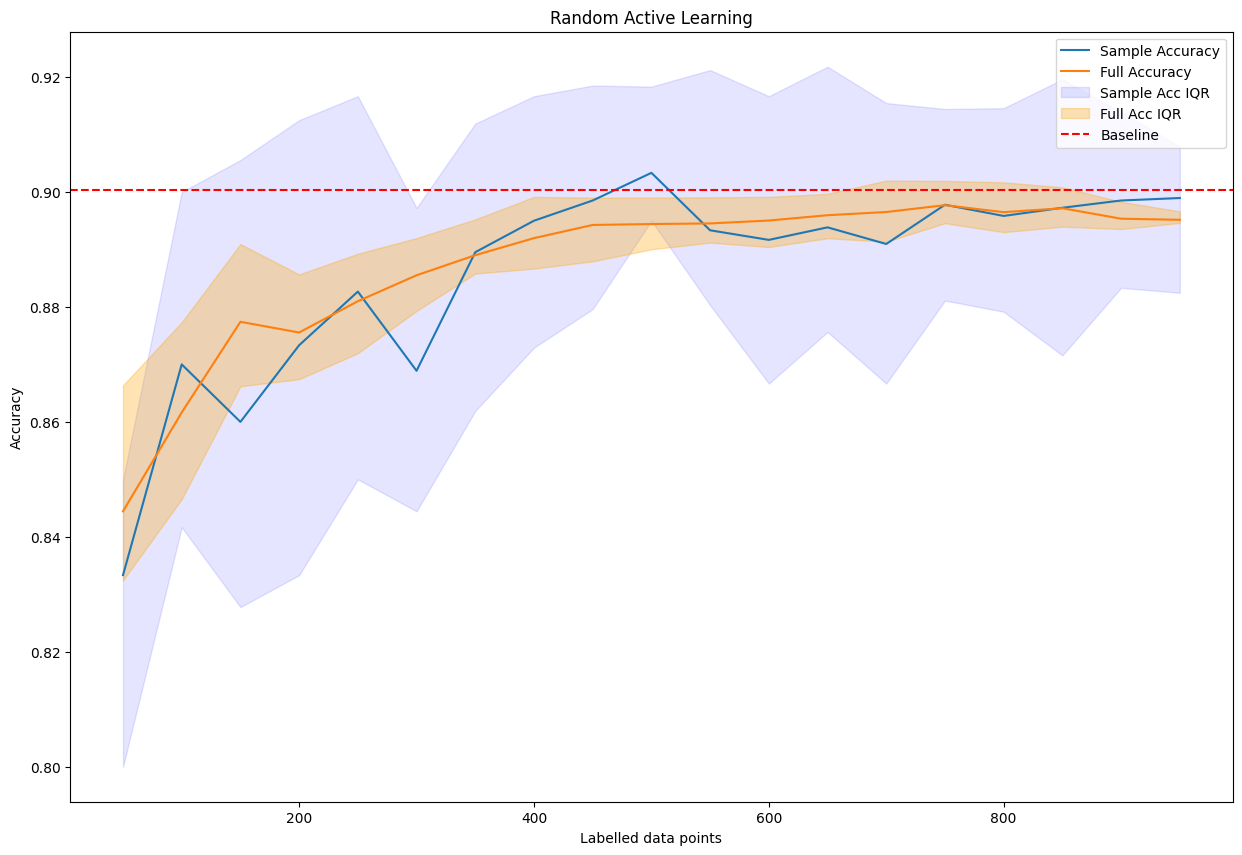

In [141]:
plot_result(accuracies_df, stats_sample_df, stats_full_df, baseline_accuracy, 'Random Active Learning', show_iqr_sample=True)

### **Uncertainty Based Active Learning**

In [142]:
tot_accuracies_u = []

for seed in range(1, 11):
    
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    #labelled_indexes = current_sample.index.tolist()
    
    step = 50
    accuracies_u = {}

    for size in range(50, 1000, step):

        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]
        
        # Update sample  -- Uncertainty based
        predicted_proba = model.predict_proba(full_X_train_scaled)
        predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=non_labelled_df.index)
        predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
        top_50_uncertain_points = predicted_proba_df.nsmallest(step, 'uncertainty_diff')

        to_be_labelled = non_labelled_df.loc[top_50_uncertain_points.index]

        # Update labelled_indexes with the indexes of the top 50 uncertain points
        current_sample = pd.concat([current_sample, to_be_labelled])
        non_labelled_df = non_labelled_df.drop(top_50_uncertain_points.index)

    tot_accuracies_u.append(accuracies_u)

In [143]:
list_of_dicts = tot_accuracies_u

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_u_df = pd.DataFrame(averages).T
accuracies_u_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [144]:
all_accuracies_u_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_u_df, size, element_index=0) for size in all_accuracies_u_df.columns}
stats_full = {size: compute_stats(all_accuracies_u_df, size, element_index=1) for size in all_accuracies_u_df.columns}

# Convert these stats into DataFrames
stats_sample_u_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_u_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

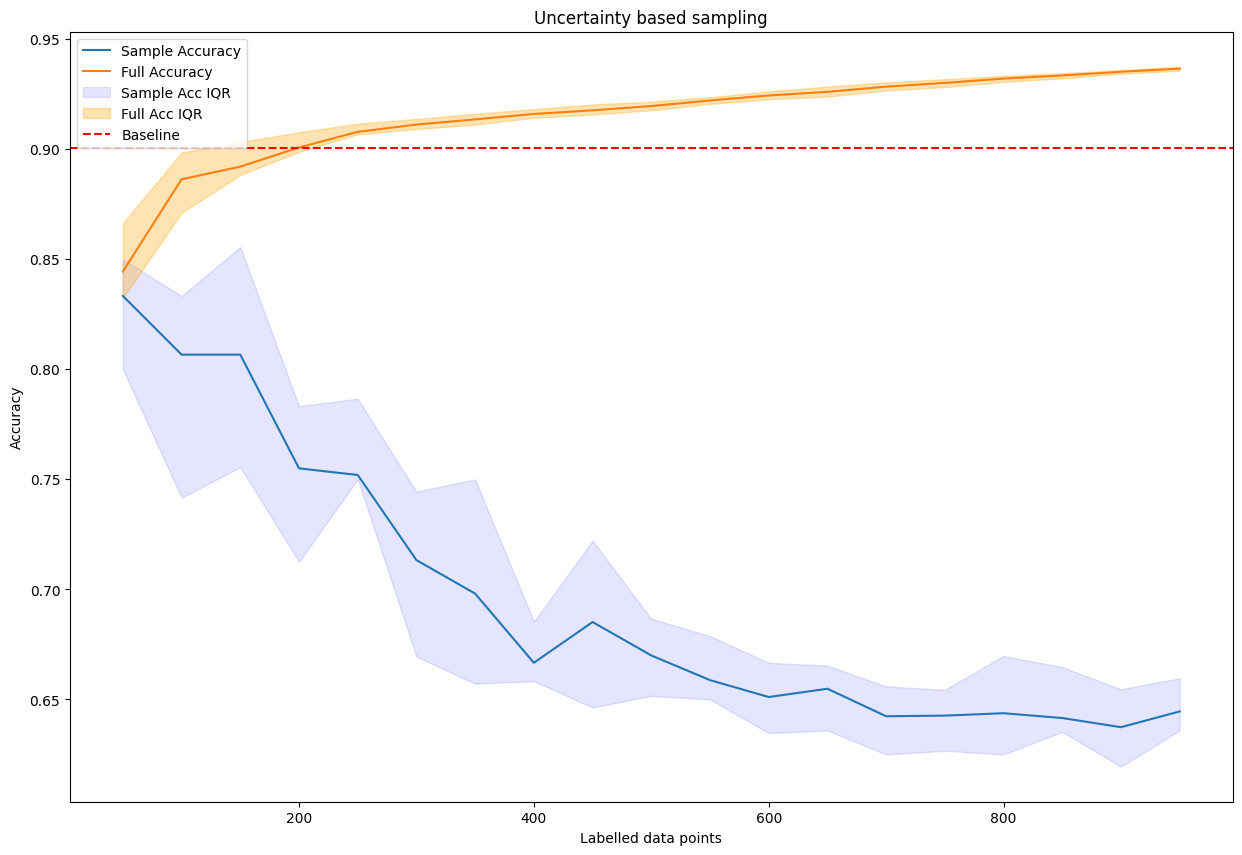

In [145]:
plot_result(accuracies_u_df, stats_sample_u_df, stats_full_u_df, baseline_accuracy, 'Uncertainty based sampling', show_iqr_sample=True)

### **Feature Distribution Based Active Learning**

In [132]:
tot_accuracies_f = []

for seed in range(1, 11):

    # Initialize sample (stratified)
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 50
    accuracies_f = {}

    for size in range(50, 1000, step):
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_f[size] = [sample_acc, full_acc]
    
        # Dissimilarity based selection
        distances = cdist(non_labelled_df, current_sample, metric='euclidean')
        mean_distances = distances.mean(axis=1)
        dissimilarity_df = pd.DataFrame(mean_distances, index=non_labelled_df.index, columns=['dissimilarity'])
        dissimilar_points = dissimilarity_df.nlargest(step, 'dissimilarity')
        to_be_labelled_dissimilarity = non_labelled_df.loc[dissimilar_points.index]

        current_sample = pd.concat([current_sample, to_be_labelled_dissimilarity])
        non_labelled_df = non_labelled_df.drop(dissimilar_points.index)

    tot_accuracies_f.append(accuracies_f)


In [133]:
list_of_dicts = tot_accuracies_f

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_f_df = pd.DataFrame(averages).T
accuracies_f_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [134]:
all_accuracies_f_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_f_df, size, element_index=0) for size in all_accuracies_f_df.columns}
stats_full = {size: compute_stats(all_accuracies_f_df, size, element_index=1) for size in all_accuracies_f_df.columns}

# Convert these stats into DataFrames
stats_sample_f_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_f_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

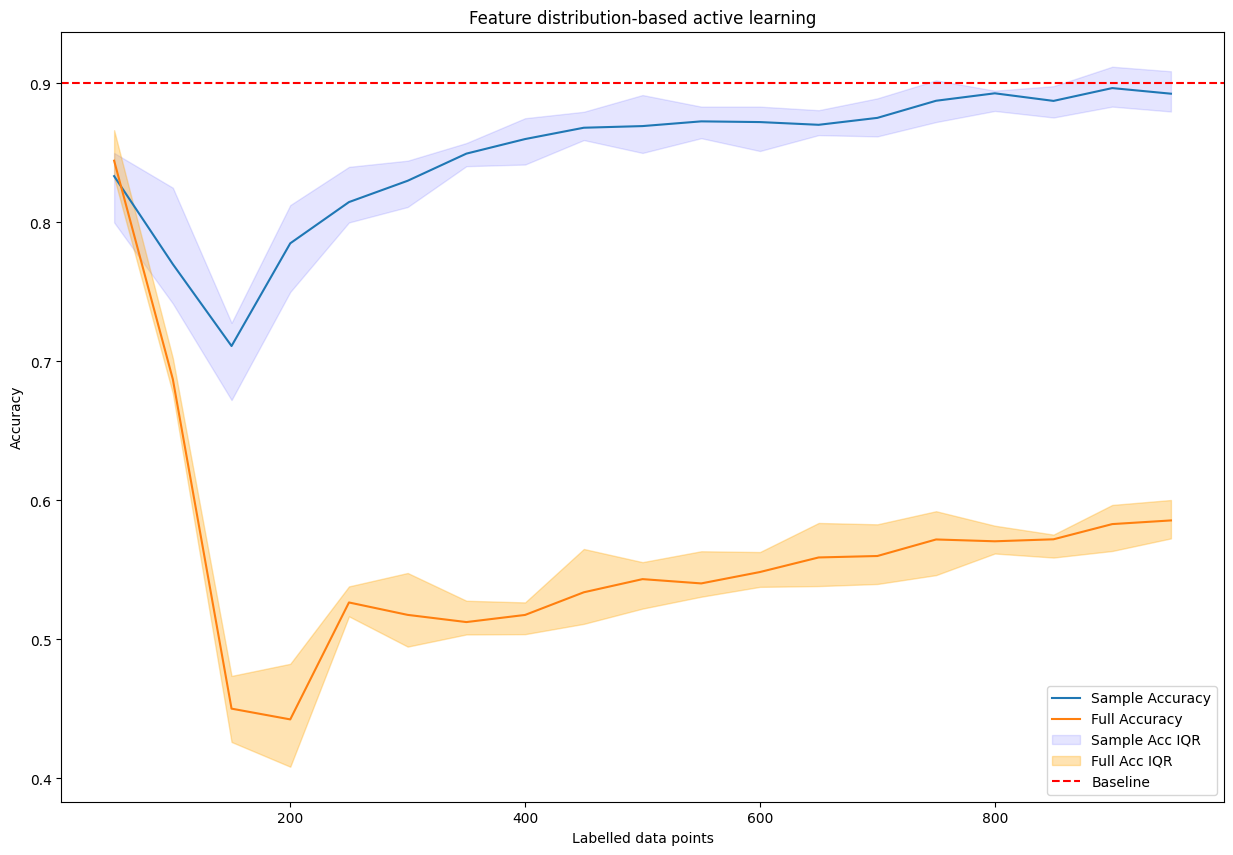

In [146]:
plot_result(accuracies_f_df, stats_sample_f_df, stats_full_f_df, baseline_accuracy, 'Feature distribution-based active learning', show_iqr_sample=True)

### **Feature Distribution and Uncertainty Based Active Learning**

In [147]:
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

tot_accuracies_uf = []

for seed in range(1, 11):

    # Initialize sample (stratified)
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 50
    accuracies_uf = {}

    for size in range(50, 1000, step):
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_uf[size] = [sample_acc, full_acc]

        # Uncertainty based selection
        predicted_proba = model.predict_proba(full_X_train_scaled)
        predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=non_labelled_df.index)
        predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
        top_50_uncertain_points = predicted_proba_df.nsmallest(step//2, 'uncertainty_diff')
        to_be_labelled_uncertainty = non_labelled_df.loc[top_50_uncertain_points.index]

        current_sample = pd.concat([current_sample, to_be_labelled_uncertainty])
        non_labelled_df = non_labelled_df.drop(top_50_uncertain_points.index)
    
        # Dissimilarity based selection
        distances = cdist(non_labelled_df, current_sample, metric='euclidean')
        mean_distances = distances.mean(axis=1)
        dissimilarity_df = pd.DataFrame(mean_distances, index=non_labelled_df.index, columns=['dissimilarity'])
        dissimilar_points = dissimilarity_df.nlargest(step//2, 'dissimilarity')
        to_be_labelled_dissimilarity = non_labelled_df.loc[dissimilar_points.index]

        current_sample = pd.concat([current_sample, to_be_labelled_dissimilarity])
        non_labelled_df = non_labelled_df.drop(dissimilar_points.index)

    tot_accuracies_uf.append(accuracies_uf)


In [148]:
list_of_dicts = tot_accuracies_uf

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_uf_df = pd.DataFrame(averages).T
accuracies_uf_df.columns = ['Sample Accuracy', 'Full Accuracy']

In [149]:
all_accuracies_uf_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_uf_df, size, element_index=0) for size in all_accuracies_uf_df.columns}
stats_full = {size: compute_stats(all_accuracies_uf_df, size, element_index=1) for size in all_accuracies_uf_df.columns}

# Convert these stats into DataFrames
stats_sample_uf_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_uf_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T

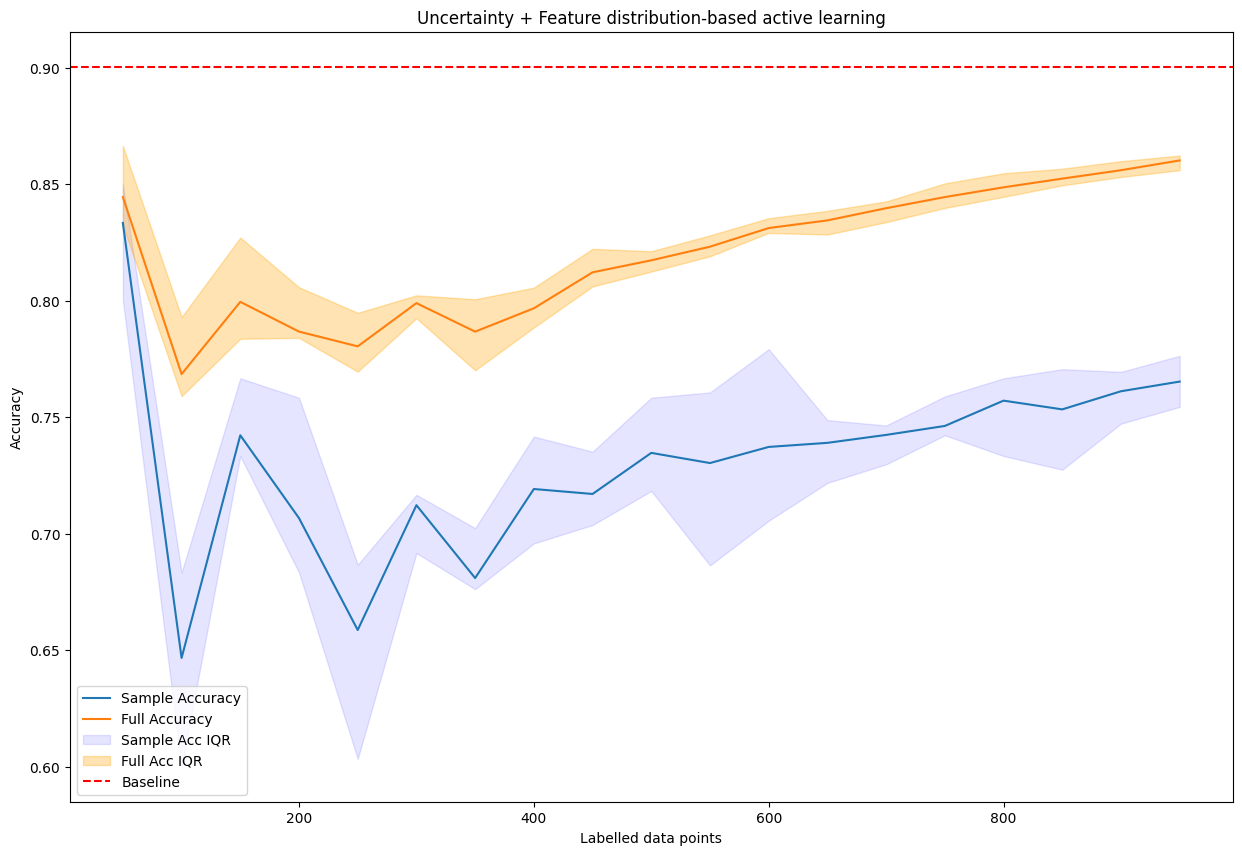

In [150]:
plot_result(accuracies_uf_df, stats_sample_uf_df, stats_full_uf_df, baseline_accuracy, 'Uncertainty + Feature distribution-based active learning', show_iqr_sample=True)

## **Summary of Baseline**

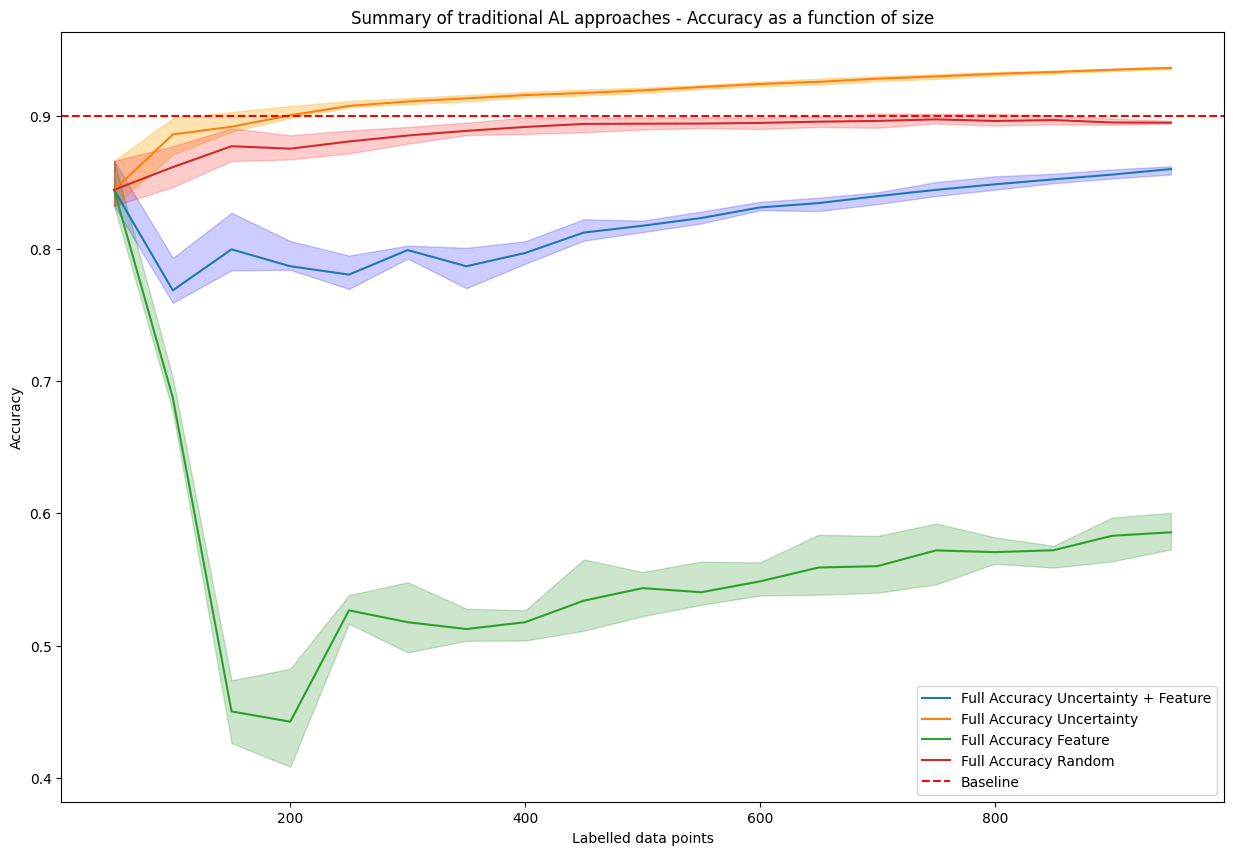

In [151]:
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Full Accuracy'], label='Full Accuracy Uncertainty + Feature')
plt.fill_between(accuracies_uf_df.reset_index()['index'], stats_full_uf_df['25%'], stats_full_uf_df['75%'], color='blue', alpha=0.2)

plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Full Accuracy'], label='Full Accuracy Uncertainty')
plt.fill_between(accuracies_u_df.reset_index()['index'], stats_full_u_df['25%'], stats_full_u_df['75%'], color='orange', alpha=0.3)

plt.plot(accuracies_f_df.reset_index()['index'], accuracies_f_df['Full Accuracy'], label='Full Accuracy Feature')
plt.fill_between(accuracies_f_df.reset_index()['index'], stats_full_f_df['25%'], stats_full_f_df['75%'], color='green', alpha=0.2)

plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy Random')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='red', alpha=0.2)

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Summary of traditional AL approaches - Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

# **Optimization Model**

In [8]:
from gurobipy import Model, GRB

# Reading CSV files
supply = pd.read_csv("data/opti-origin_supply.csv")["Value"].to_numpy()
tr_capacity = pd.read_csv("data/opti-transshipment_capacity.csv")["Value"].to_numpy()
des_capacity = pd.read_csv("data/opti-destination_capacity.csv")["Value"].to_numpy()

cost_1 = pd.read_csv("data/opti-origin_to_transshipment_cost.csv")
cost_1 = cost_1.pivot(index='Origin', columns='Hub', values='Value').fillna(0).to_numpy()

cost_2 = pd.read_csv("data/opti-transshipment_to_destination_cost.csv")
cost_2 = cost_2.pivot(index='Hub', columns='Destination', values='Value').fillna(0).to_numpy()

In [9]:
## To be used for I-SET active learning

cost_2_df = pd.DataFrame(cost_2)
cost_2_df = cost_2_df.reset_index().rename(columns={'index':'j'})
cost_2_df = cost_2_df.melt(id_vars=['j'], var_name='k', value_name='cost')

cost_2_df.head()

,j,k,cost
0,0,0,46
1,1,0,21
2,2,0,3
3,3,0,37
4,4,0,57


### **Optimization model baseline (full information)**

In [47]:
def solve_opti_model(z):

    z_capacity = z * des_capacity


    # Create a new model
    m = Model("optimization")
    m.setParam('OutputFlag', 0)

    # Add variables
    X = m.addVars(len(supply), len(tr_capacity), lb=0, name="X")
    Y = m.addVars(len(tr_capacity), len(des_capacity), lb=0, name="Y")

    # Set objective
    m.setObjective(sum(cost_1[i, j] * X[i, j] for i in range(len(supply)) for j in range(len(tr_capacity))) +
                sum(cost_2[j, k] * Y[j, k] for j in range(len(tr_capacity)) for k in range(len(des_capacity))),GRB.MINIMIZE)

    # Add constraints 
    for i in range(len(supply)):  # 6 constraints
        m.addConstr(sum(X[i, j] for j in range(len(tr_capacity))) == supply[i], "Supply_%d" % i)

    for j in range(len(tr_capacity)): # 8 constraints
        m.addConstr(sum(X[i, j] for i in range(len(supply))) <= tr_capacity[j], "TransCapacity_%d" % j)

    for k in range(len(des_capacity)): # 10000 constraints
        m.addConstr(sum(Y[j, k] for j in range(len(tr_capacity))) <= z_capacity[k], "Link_%d" % k)

    # What goes in comes out
    for j in range(len(tr_capacity)): # 8 constraints
        m.addConstr(sum(X[i, j] for i in range(len(supply))) == sum(Y[j, k] for k in range(len(des_capacity))), f"TransshipmentBalance_{j}")


    # Optimize model
    m.optimize()

    if m.status == GRB.OPTIMAL:
        opt_objective = m.ObjVal

        # For X variables
        opt_X = [(f"X[{i},{j}]", X[i, j].X) for i in range(len(supply)) for j in range(len(tr_capacity))]
        df_X = pd.DataFrame(opt_X, columns=["Variable", "Value"])

        # For Y variables
        opt_Y = [(f"Y[{j},{k}]", Y[j, k].X) for j in range(len(tr_capacity)) for k in range(len(des_capacity))]
        df_Y = pd.DataFrame(opt_Y, columns=["Variable", "Value"])
        df_Y['j'] = df_Y['Variable'].apply(lambda x: int(x.split(',')[0].split('[')[1]))
        df_Y['k'] = df_Y['Variable'].apply(lambda x: int(x.split(',')[1].split(']')[0]))
        df_Y.drop('Variable', axis=1, inplace=True)

        link_duals = [(f"Link_{k}", m.getConstrByName(f"Link_{k}").Pi) for k in range(len(des_capacity))]
        link_slacks = [(f"Link_{k}", m.getConstrByName(f"Link_{k}").Slack) for k in range(len(des_capacity))]
        df_link_duals = pd.DataFrame(link_duals, columns=["Constraint", "Dual Value"])
        df_slacks = pd.DataFrame(link_slacks, columns=["Constraint", "Slack"])
        df_link_duals = pd.merge(df_slacks, df_link_duals, on="Constraint")
        dual_df = pd.merge(df_link_duals, df[['Suitable']], left_index=True, right_index=True)
        capacity_df = pd.DataFrame(des_capacity).rename(columns={0:'Capacity'})
        dual_df = pd.merge(dual_df, capacity_df, left_index=True, right_index=True)
        
        return opt_objective, df_X, df_Y, dual_df
    
    else:
        print("Infeasible")
        return 0, 0, 0, 0

In [48]:
z = df['Suitable'].to_numpy()

opt_objective, df_X, df_Y, dual_df = solve_opti_model(z)

In [49]:
full_info_objective = opt_objective

print(f"Optimal Objective Value: {opt_objective}")

Optimal Objective Value: 14933590.0


In [50]:
dual_df

,Constraint,Slack,Dual Value,Suitable,Capacity
0,Link_0,0.0,-11.0,1,71
1,Link_1,0.0,-12.0,0,74
2,Link_2,0.0,0.0,0,56
3,Link_3,0.0,-4.0,0,80
4,Link_4,0.0,-9.0,1,55
...,...,...,...,...,...
9995,Link_9995,0.0,0.0,0,59
9996,Link_9996,0.0,0.0,0,96
9997,Link_9997,0.0,-6.0,0,92
9998,Link_9998,0.0,-10.0,1,77


In [51]:
df_Y_optimal = df_Y
df_Y_optimal

,Value,j,k
0,0.0,0,0
1,0.0,0,1
2,0.0,0,2
3,0.0,0,3
4,0.0,0,4
...,...,...,...
79995,0.0,7,9995
79996,0.0,7,9996
79997,0.0,7,9997
79998,0.0,7,9998


In [14]:
dual_df[(dual_df['Suitable']==0) & (dual_df['Dual Value']!=0)].sort_values(by='Dual Value', ascending=True)

,Constraint,Slack,Dual Value,Suitable,Capacity
1244,Link_1244,0.0,-13.0,0,88
1447,Link_1447,0.0,-13.0,0,67
7475,Link_7475,0.0,-13.0,0,67
3096,Link_3096,0.0,-13.0,0,55
3106,Link_3106,0.0,-13.0,0,72
...,...,...,...,...,...
7719,Link_7719,0.0,-1.0,0,76
554,Link_554,0.0,-1.0,0,51
3454,Link_3454,0.0,-1.0,0,99
7671,Link_7671,0.0,-1.0,0,66


In [15]:
merged_cost = pd.merge(df_Y, cost_2_df, on=['j', 'k'], how='left')

merged_cost.groupby('k')[['Value']].sum().sort_values(by='Value', ascending=False).reset_index()

,k,Value
0,7608,100.0
1,5821,100.0
2,1318,100.0
3,8873,100.0
4,4746,100.0
...,...,...
4667,1438,50.0
4668,3187,50.0
4669,4711,50.0
4670,9729,50.0


### **Optimization-based active learning** - O-set only

In [69]:
# Average across seeds to get a more robust result:
tot_accuracies_o_set_only = []

for seed in range(1, 2):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        # Compute Z hat vector
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']

        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        # Solve optimization model
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        # Indexes of highest dual variables
        if opt_objective > 0: # feasible

            ### O SET - DUAL VARIABLES
            dual_df = pd.merge(dual_df, z_hat_df[['z_hat_adjusted']], left_index=True, right_index=True, how='left')
            O_set = dual_df[(dual_df['z_hat_adjusted']==0) & (dual_df['Dual Value']!=0)].sort_values(by='Dual Value', ascending=True)
            O_set_without_labelled = O_set[~O_set.index.isin(current_sample.index)]

            indexes = O_set_without_labelled.head(step).index
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])


    tot_accuracies_o_set_only.append(accuracies)

In [70]:
list_of_dicts = tot_accuracies_o_set_only

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

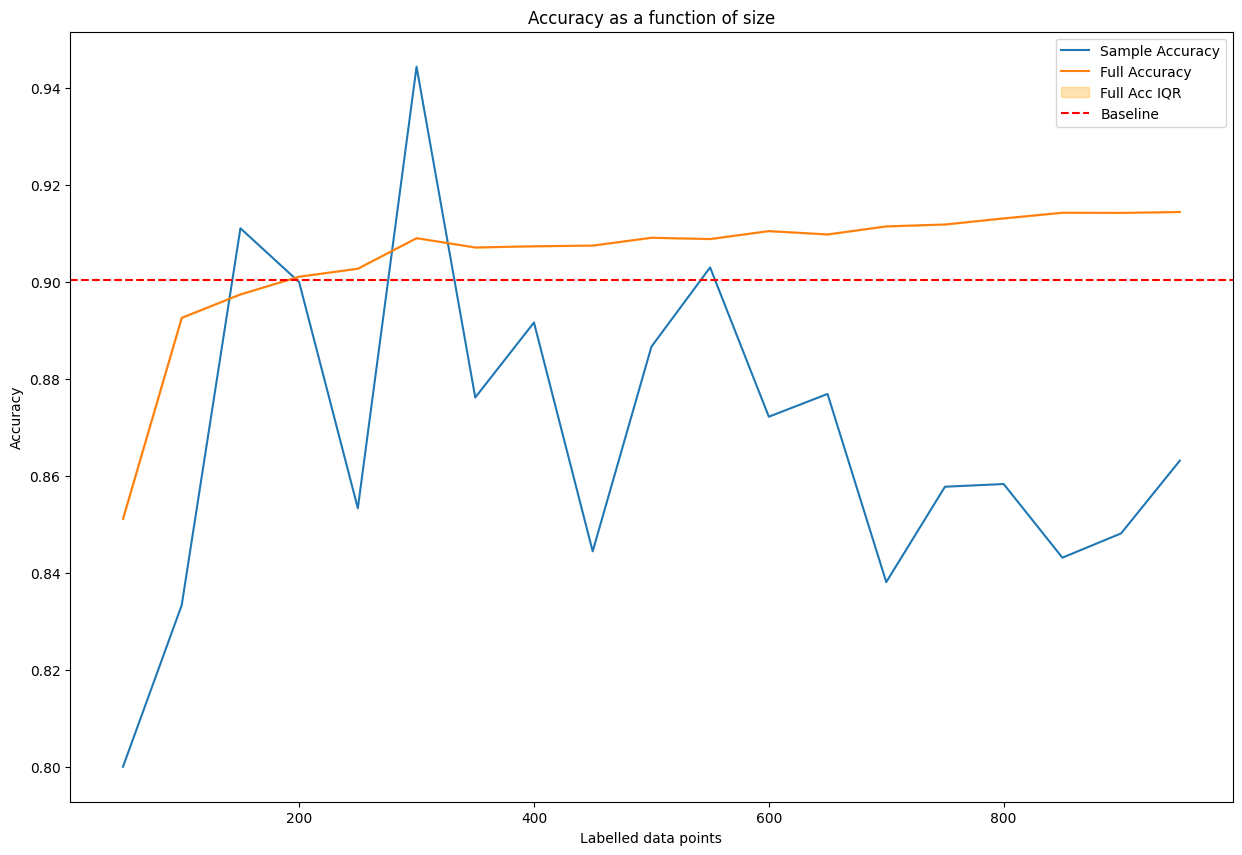

In [71]:
def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
# plt.fill_between(accuracies_df.reset_index()['index'], stats_sample_df['25%'], stats_sample_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

### **Optimization-based active learning** - I-set only

In [109]:
# Average across seeds to get a more robust result:
tot_accuracies_i_set_only = []

for seed in range(1, 5):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        # Compute Z hat vector
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']

        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        # Solve optimization model
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        # Indexes of highest dual variables
        if opt_objective > 0: # feasible
            ### I SET - COST

            merged_cost = pd.merge(df_Y, cost_2_df, on=['j', 'k'], how='left')
            I_set = merged_cost.groupby('k')[['Value']].sum().sort_values(by='Value', ascending=False).reset_index()

            I_set_without_labelled = I_set[~I_set['k'].isin(current_sample.index)]

            indexes = I_set_without_labelled.head(step)['k'].tolist()
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])
            
    tot_accuracies_i_set_only.append(accuracies)

In [110]:
list_of_dicts = tot_accuracies_i_set_only

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

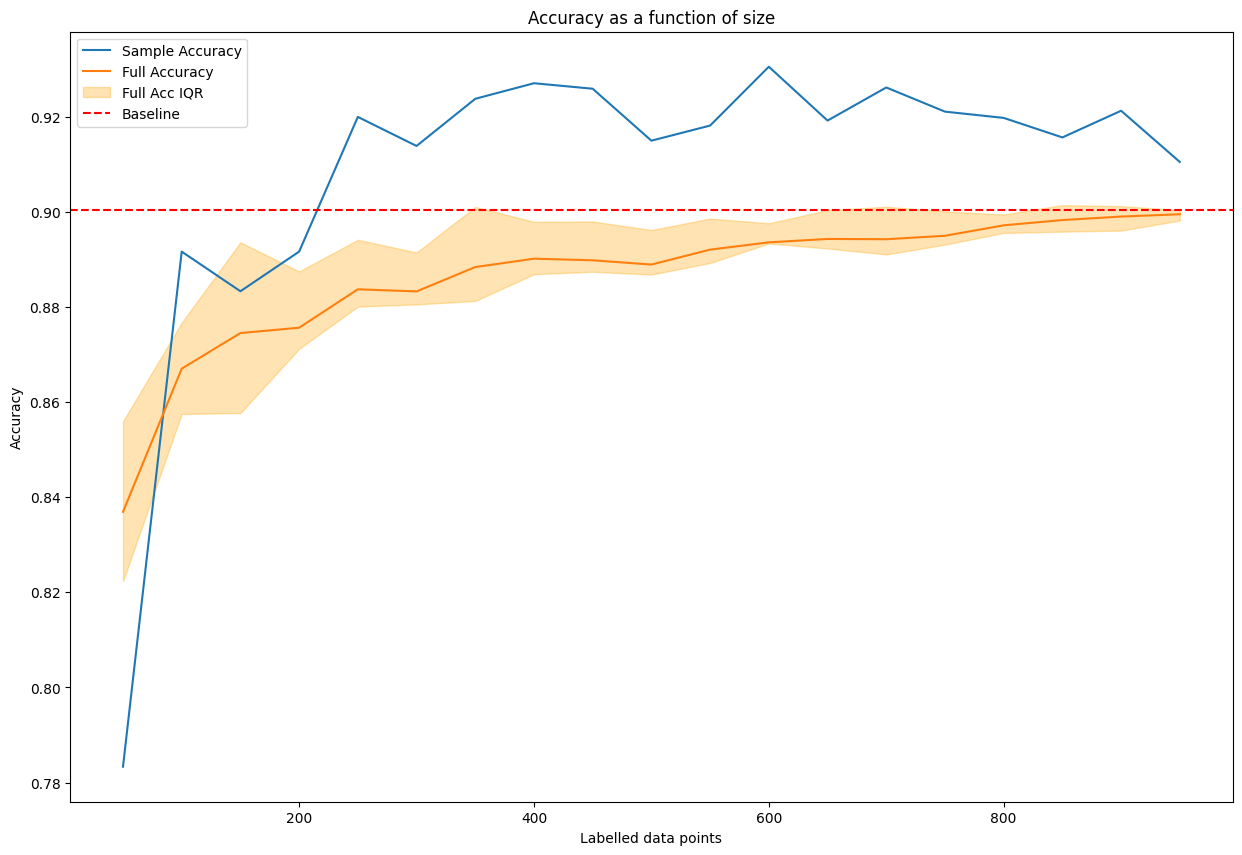

In [111]:
def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
# plt.fill_between(accuracies_df.reset_index()['index'], stats_sample_df['25%'], stats_sample_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

### **Optimization-based active learning** - O-set and I-set

In [113]:
# Average across seeds to get a more robust result:
tot_accuracies_o_and_i_set = []

for seed in range(1, 5):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        # Compute Z hat vector
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']

        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        # Solve optimization model
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        # Indexes of highest dual variables
        if opt_objective > 0: # feasible


            ### O SET - DUAL VARIABLES
            dual_df = pd.merge(dual_df, z_hat_df[['z_hat_adjusted']], left_index=True, right_index=True, how='left')
            O_set = dual_df[(dual_df['z_hat_adjusted']==0) & (dual_df['Dual Value']!=0)].sort_values(by='Dual Value', ascending=True)
            O_set_without_labelled = O_set[~O_set.index.isin(current_sample.index)]

            indexes = O_set_without_labelled.head(int(step/2)).index
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])


            ### I SET - COST

            merged_cost = pd.merge(df_Y, cost_2_df, on=['j', 'k'], how='left')
            I_set = merged_cost.groupby('k')[['Value']].sum().sort_values(by='Value', ascending=False).reset_index()

            I_set_without_labelled = I_set[~I_set['k'].isin(current_sample.index)]

            indexes = I_set_without_labelled.head(int(step/2))['k'].tolist()
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])
            
    tot_accuracies_o_and_i_set.append(accuracies)

In [114]:
list_of_dicts = tot_accuracies_o_and_i_set

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

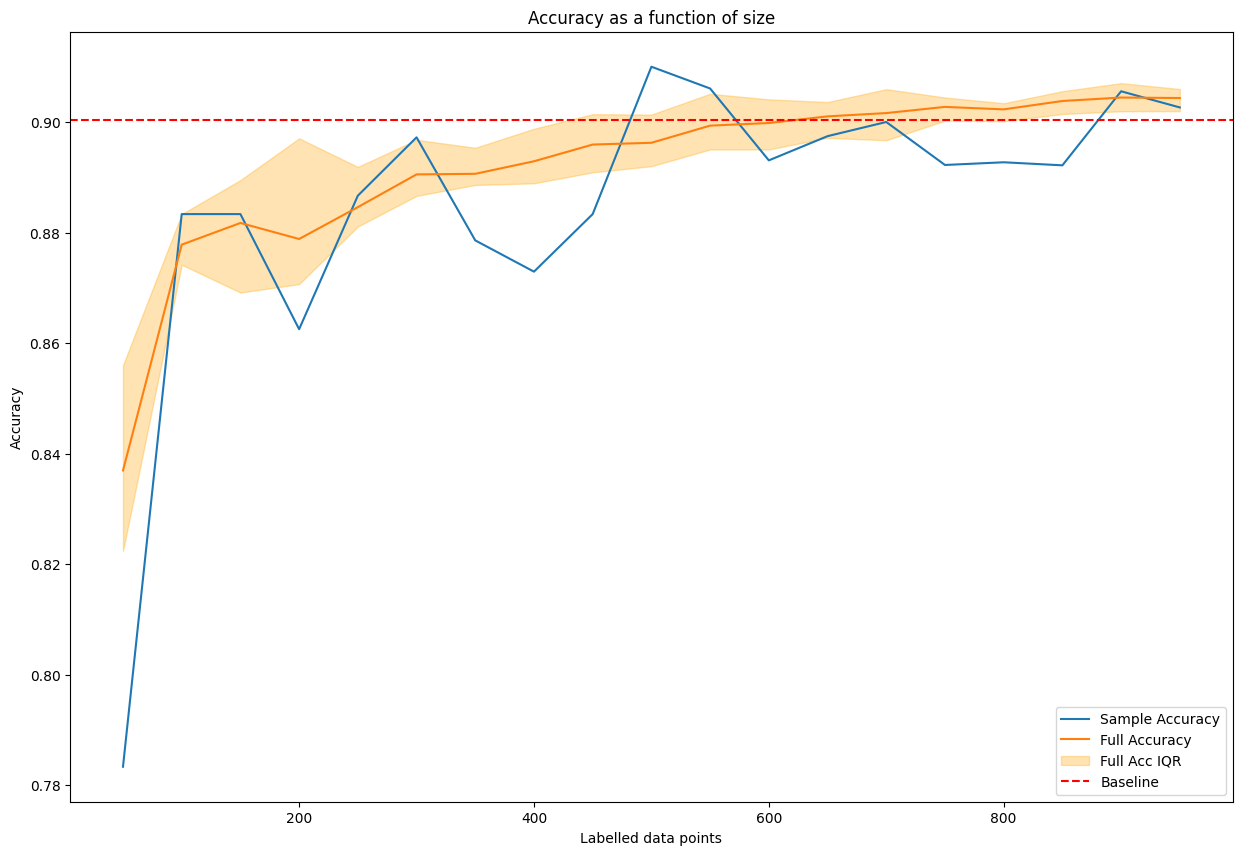

In [118]:
def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
#plt.fill_between(accuracies_df.reset_index()['index'], stats_sample_df['25%'], stats_sample_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

### **Optimization-based active learning** - Aggregate Strategies

In [ ]:
# Average across seeds to get a more robust result:
tot_accuracies_duality_feature_uncertainty = []

for seed in range(1, 5):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        # Compute Z hat vector
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']

        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        # Solve optimization model
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        # Indexes of highest dual variables
        if opt_objective > 0: # feasible
            ### O SET - DUAL VARIABLES
            dual_df = pd.merge(dual_df, z_hat_df[['z_hat_adjusted']], left_index=True, right_index=True, how='left')
            O_set = dual_df[(dual_df['z_hat_adjusted']==0) & (dual_df['Dual Value']!=0)].sort_values(by='Dual Value', ascending=True)
            O_set_without_labelled = O_set[~O_set.index.isin(current_sample.index)]

            indexes = O_set_without_labelled.head(int(step/4)).index
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])

            ### I SET - COST
            merged_cost = pd.merge(df_Y, cost_2_df, on=['j', 'k'], how='left')
            I_set = merged_cost.groupby('k')[['Value']].sum().sort_values(by='Value', ascending=False).reset_index()

            I_set_without_labelled = I_set[~I_set['k'].isin(current_sample.index)]

            indexes = I_set_without_labelled.head(int(step/4))['k'].tolist()
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])
            
            # Uncertainty based selection
            predicted_proba = model.predict_proba(full_X_train_scaled)
            predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=non_labelled_df.index)
            predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
            top_50_uncertain_points = predicted_proba_df.nsmallest(step//4, 'uncertainty_diff')
            to_be_labelled_uncertainty = non_labelled_df.loc[top_50_uncertain_points.index]

            current_sample = pd.concat([current_sample, to_be_labelled_uncertainty])
            non_labelled_df = non_labelled_df.drop(top_50_uncertain_points.index)
        
            # Dissimilarity based selection
            distances = cdist(non_labelled_df, current_sample, metric='euclidean')
            mean_distances = distances.mean(axis=1)
            dissimilarity_df = pd.DataFrame(mean_distances, index=non_labelled_df.index, columns=['dissimilarity'])
            dissimilar_points = dissimilarity_df.nlargest(step//4, 'dissimilarity')
            to_be_labelled_dissimilarity = non_labelled_df.loc[dissimilar_points.index]

            current_sample = pd.concat([current_sample, to_be_labelled_dissimilarity])
            non_labelled_df = non_labelled_df.drop(dissimilar_points.index)

#each strategy identifies 1/4 of the total batch to label.
            
    tot_accuracies_duality_feature_uncertainty.append(accuracies)

In [ ]:
list_of_dicts = tot_accuracies_duality_feature_uncertainty

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

In [ ]:
def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
# plt.fill_between(accuracies_df.reset_index()['index'], stats_sample_df['25%'], stats_sample_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

## **Evaluation of Optmization solution Loss Function**

### **Random Active Learning**

In [64]:
# Average across seeds to get a more robust result:
tot_accuracies = []
tot_objective_factor = []
tot_layout_factor = []

for seed in range(1, 6):
    print(f"Seed: {seed}")
    accuracies = {}
    losses = {}
    objective_factors = {}
    layout_factors = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 50

    for size in range(50, 1000, step):        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]
        
        # Get new sample
        new_labels = not_labelled_df.sample(n=step, random_state = seed)

        # Update datasets
        not_labelled_df = not_labelled_df.drop(new_labels.index)
        current_sample = pd.concat([current_sample, new_labels])

        ### RUN OPT MODEL
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])  # Adjust by setting the known labels

        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)

            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()

            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor
            
    tot_accuracies.append(accuracies)
    tot_objective_factor.append(objective_factors)
    tot_layout_factor.append(layout_factors)

Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5


#### Accuracies Results

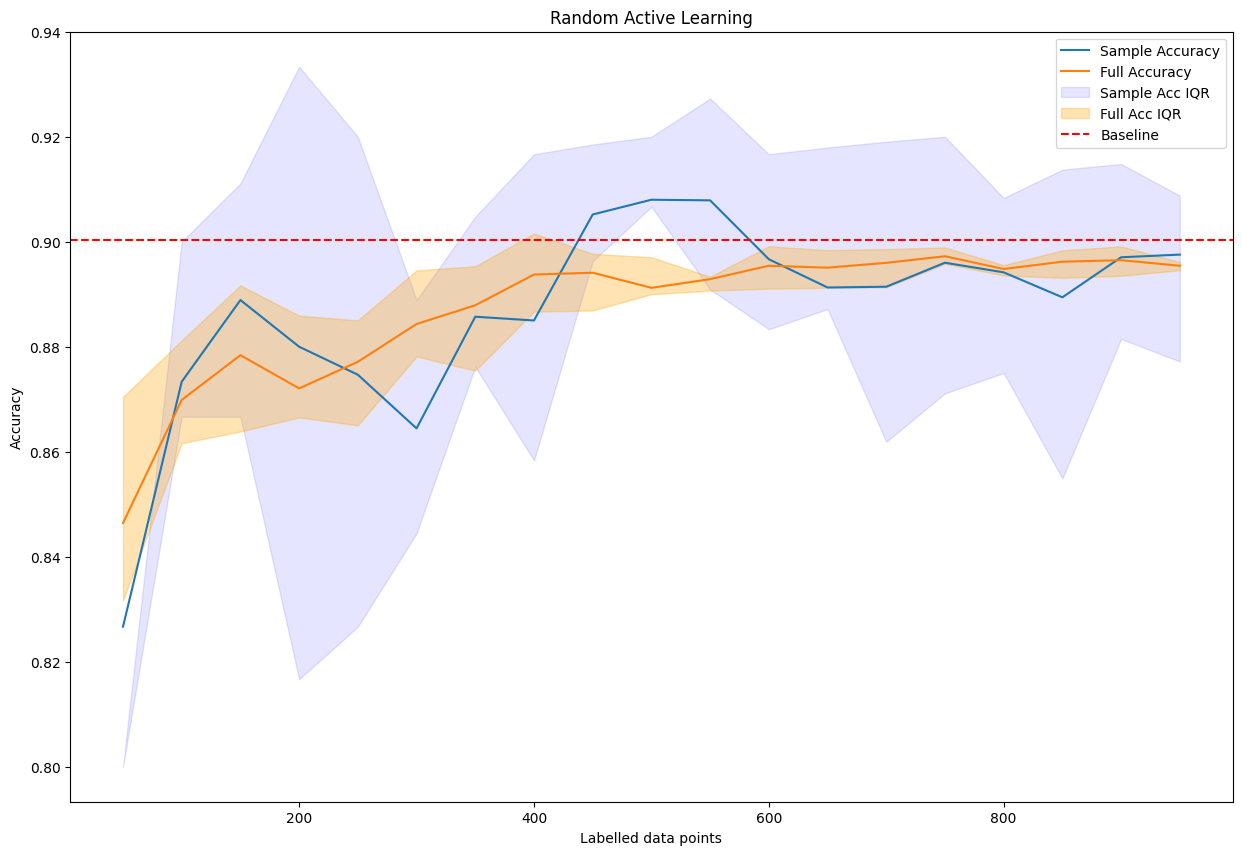

In [66]:
list_of_dicts = tot_accuracies

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
plot_result(accuracies_df, stats_sample_df, stats_full_df, baseline_accuracy, 'Random Active Learning', show_iqr_sample=True)

#### Optimization Results

In [110]:
## Build layout factor
layout_factor = pd.DataFrame.from_dict(tot_layout_factor[0], orient='index').reset_index()
layout_factor.columns = ['seed',f"value_{0}"]

for seed in range(1, len(tot_layout_factor)):
    
    df1 = pd.DataFrame.from_dict(tot_layout_factor[seed], orient='index').reset_index()
    df1.columns = ['seed',f"value_{seed}"]

    layout_factor = pd.merge(layout_factor, df1, on='seed')

layout_factor['average'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].mean(axis=1)
layout_factor['third_qnt'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.75, axis=1)
layout_factor['first_qnt'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.25, axis=1)

layout_factor.drop(['value_0','value_1','value_2','value_3','value_4'], axis=1, inplace=True)

# Build objective factor
objective_factor = pd.DataFrame.from_dict(tot_objective_factor[0], orient='index').reset_index()
objective_factor.columns = ['seed',f"value_{0}"]

for seed in range(1, len(tot_objective_factor)):
    
    df1 = pd.DataFrame.from_dict(tot_objective_factor[seed], orient='index').reset_index()
    df1.columns = ['seed',f"value_{seed}"]

    objective_factor = pd.merge(objective_factor, df1, on='seed')

objective_factor['average'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].mean(axis=1)
objective_factor['third_qnt'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.75, axis=1)
objective_factor['first_qnt'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.25, axis=1)

objective_factor.drop(['value_0','value_1','value_2','value_3','value_4'], axis=1, inplace=True)


layout_factor_random = layout_factor
layout_factor_random.rename(columns={'seed':'Size'}, inplace=True)

objective_factor_random = objective_factor
objective_factor_random.rename(columns={'seed':'Size'}, inplace=True)

**Layout Factor**

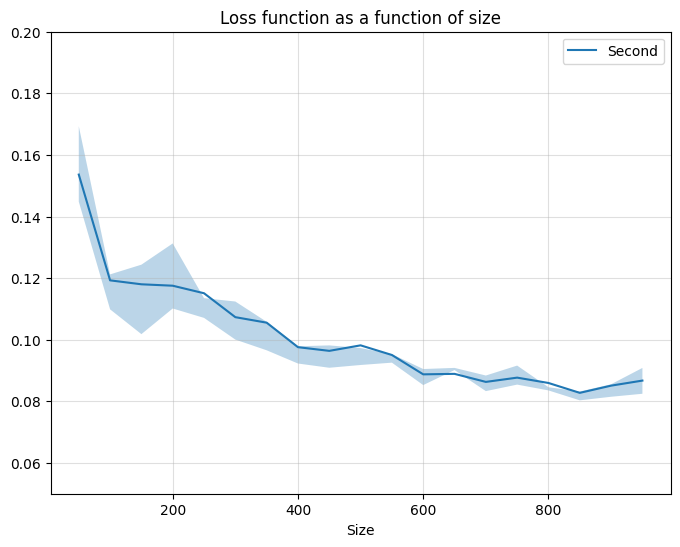

In [111]:
fig, ax = plt.subplots(figsize=(8,6))

layout_factor_random.plot(x='Size', y='average', ax=ax, label='Second')
ax.fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.3)
ax.set_ylim([0.05,0.2])
plt.title('Loss function as a function of size')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

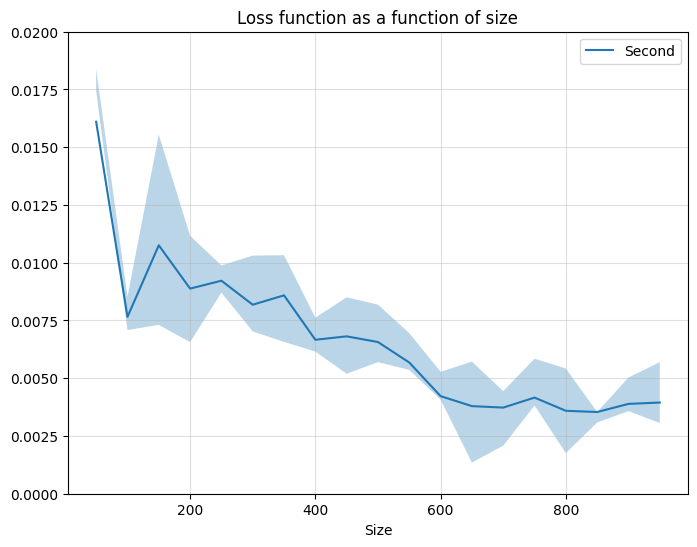

In [112]:
fig, ax = plt.subplots(figsize=(8,6))

objective_factor_random.plot(x='Size', y='average', ax=ax, label='Second')
ax.fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.3)
ax.set_ylim([0,0.02])
plt.title('Loss function as a function of size')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

### **Duality AL**

In [100]:
# Average across seeds to get a more robust result:
tot_accuracies_duality = []
tot_objective_factor_duality = []
tot_layout_factor_duality = []

for seed in range(1, 6):
    print(f"{seed}")
        
    accuracies = {}
    objective_factors = {}
    layout_factors = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        # Compute Z hat vector
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']

        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        # Solve optimization model
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        # Indexes of highest dual variables
        if opt_objective > 0: # feasible
            ### O SET - DUAL VARIABLES
            dual_df = pd.merge(dual_df, z_hat_df[['z_hat_adjusted']], left_index=True, right_index=True, how='left')
            O_set = dual_df[(dual_df['z_hat_adjusted']==0) & (dual_df['Dual Value']!=0)].sort_values(by='Dual Value', ascending=True)
            O_set_without_labelled = O_set[~O_set.index.isin(current_sample.index)]
            indexes = O_set_without_labelled.head(int(step/2)).index
            new_labels = not_labelled_df.loc[indexes]
            not_labelled_df = not_labelled_df.drop(new_labels.index)
            current_sample = pd.concat([current_sample, new_labels])

            ### I SET - COST
            merged_cost = pd.merge(df_Y, cost_2_df, on=['j', 'k'], how='left')
            I_set = merged_cost.groupby('k')[['Value']].sum().sort_values(by='Value', ascending=False).reset_index()
            I_set_without_labelled = I_set[~I_set['k'].isin(current_sample.index)]
            indexes = I_set_without_labelled.head(int(step/2))['k'].tolist()
            new_labels = not_labelled_df.loc[indexes]
            not_labelled_df = not_labelled_df.drop(new_labels.index)
            current_sample = pd.concat([current_sample, new_labels])

            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)

            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor
            
    tot_accuracies_duality.append(accuracies)
    tot_objective_factor_duality.append(objective_factors)
    tot_layout_factor_duality.append(layout_factors)


1
2
3
4
5


#### Accuracies Results

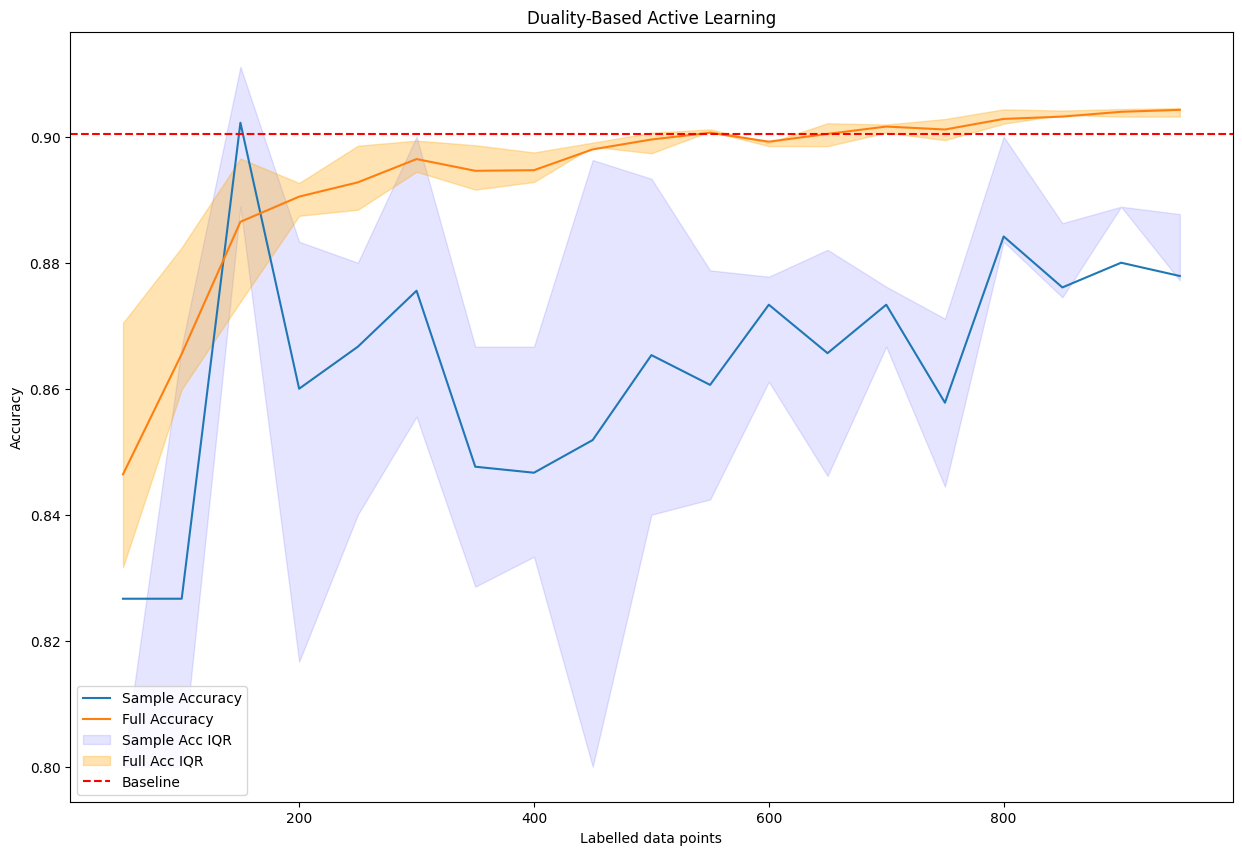

In [102]:
list_of_dicts = tot_accuracies_duality

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
plot_result(accuracies_df, stats_sample_df, stats_full_df, baseline_accuracy, 'Duality-Based Active Learning', show_iqr_sample=True)

#### Optimization Results

In [107]:
## Build layout factor
layout_factor = pd.DataFrame.from_dict(tot_layout_factor_duality[0], orient='index').reset_index()
layout_factor.columns = ['seed',f"value_{0}"]

for seed in range(1, len(tot_layout_factor_duality)):
    
    df1 = pd.DataFrame.from_dict(tot_layout_factor_duality[seed], orient='index').reset_index()
    df1.columns = ['seed',f"value_{seed}"]

    layout_factor = pd.merge(layout_factor, df1, on='seed')

layout_factor['average'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].mean(axis=1)
layout_factor['third_qnt'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.75, axis=1)
layout_factor['first_qnt'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.25, axis=1)

layout_factor.drop(['value_0','value_1','value_2','value_3','value_4'], axis=1, inplace=True)

# Build objective factor
objective_factor = pd.DataFrame.from_dict(tot_objective_factor_duality[0], orient='index').reset_index()
objective_factor.columns = ['seed',f"value_{0}"]

for seed in range(1, len(tot_objective_factor_duality)):
    
    df1 = pd.DataFrame.from_dict(tot_objective_factor_duality[seed], orient='index').reset_index()
    df1.columns = ['seed',f"value_{seed}"]

    objective_factor = pd.merge(objective_factor, df1, on='seed')

objective_factor['average'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].mean(axis=1)
objective_factor['third_qnt'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.75, axis=1)
objective_factor['first_qnt'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.25, axis=1)

objective_factor.drop(['value_0','value_1','value_2','value_3','value_4'], axis=1, inplace=True)


layout_factor_duality = layout_factor
layout_factor_duality.rename(columns={'seed':'Size'}, inplace=True)

objective_factor_duality = objective_factor
objective_factor_duality.rename(columns={'seed':'Size'}, inplace=True)

**Layout Factor**

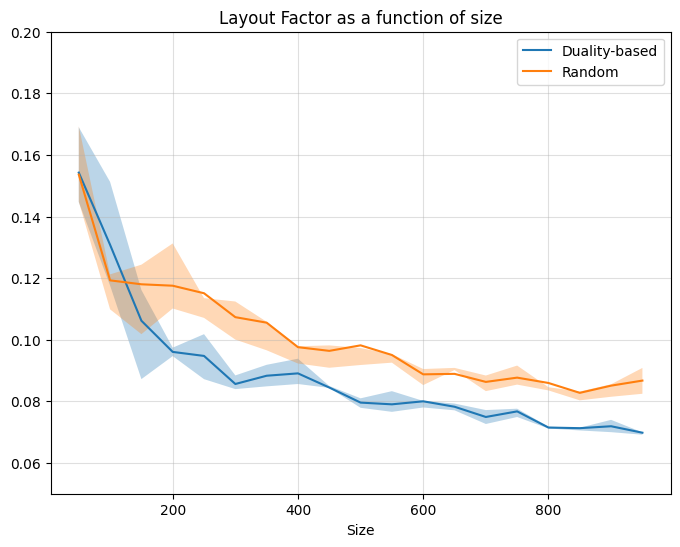

In [114]:
fig, ax = plt.subplots(figsize=(12,8))

layout_factor_duality.plot(x='Size', y='average', ax=ax, label='Duality-based')
ax.fill_between(layout_factor_duality['Size'], layout_factor_duality['first_qnt'], layout_factor_duality['third_qnt'], alpha=0.3)

layout_factor_random.plot(x='Size', y='average', ax=ax, label='Random')
ax.fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.3)

ax.set_ylim([0.05,0.2])
plt.title('Layout Factor as a function of size')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

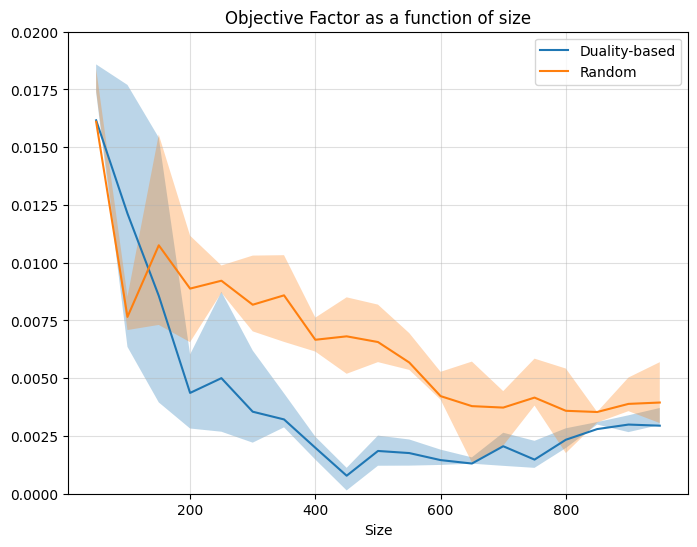

In [116]:
fig, ax = plt.subplots(figsize=(12,8))

objective_factor_duality.plot(x='Size', y='average', ax=ax, label='Duality-based')
ax.fill_between(objective_factor_duality['Size'], objective_factor_duality['first_qnt'], objective_factor_duality['third_qnt'], alpha=0.3)

objective_factor_random.plot(x='Size', y='average', ax=ax, label='Random')
ax.fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.3)

ax.set_ylim([0,0.02])
plt.title('Objective Factor as a function of size')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

### **Uncertainty based**

In [117]:
tot_accuracies_uncertainty = []
tot_objective_factor_uncertainty = []
tot_layout_factor_uncertainty = []

for seed in range(1, 6):
    print(f"{seed}")
    accuracies_u = {}
    objective_factors = {}
    layout_factors = {}

    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 50
    
    for size in range(50, 1000, step):
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]
        
        # Update sample  -- Uncertainty based
        predicted_proba = model.predict_proba(full_X_train_scaled)
        predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=non_labelled_df.index)
        predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
        top_50_uncertain_points = predicted_proba_df.nsmallest(step, 'uncertainty_diff')
        to_be_labelled = non_labelled_df.loc[top_50_uncertain_points.index]

        current_sample = pd.concat([current_sample, to_be_labelled])
        non_labelled_df = non_labelled_df.drop(top_50_uncertain_points.index)

        ### RUN OPTI MODEL
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])

        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        if opt_objective > 0: # feasible

            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)

            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor
            
    tot_accuracies_uncertainty.append(accuracies)
    tot_objective_factor_uncertainty.append(objective_factors)
    tot_layout_factor_uncertainty.append(layout_factors)

1
2
3
4
5


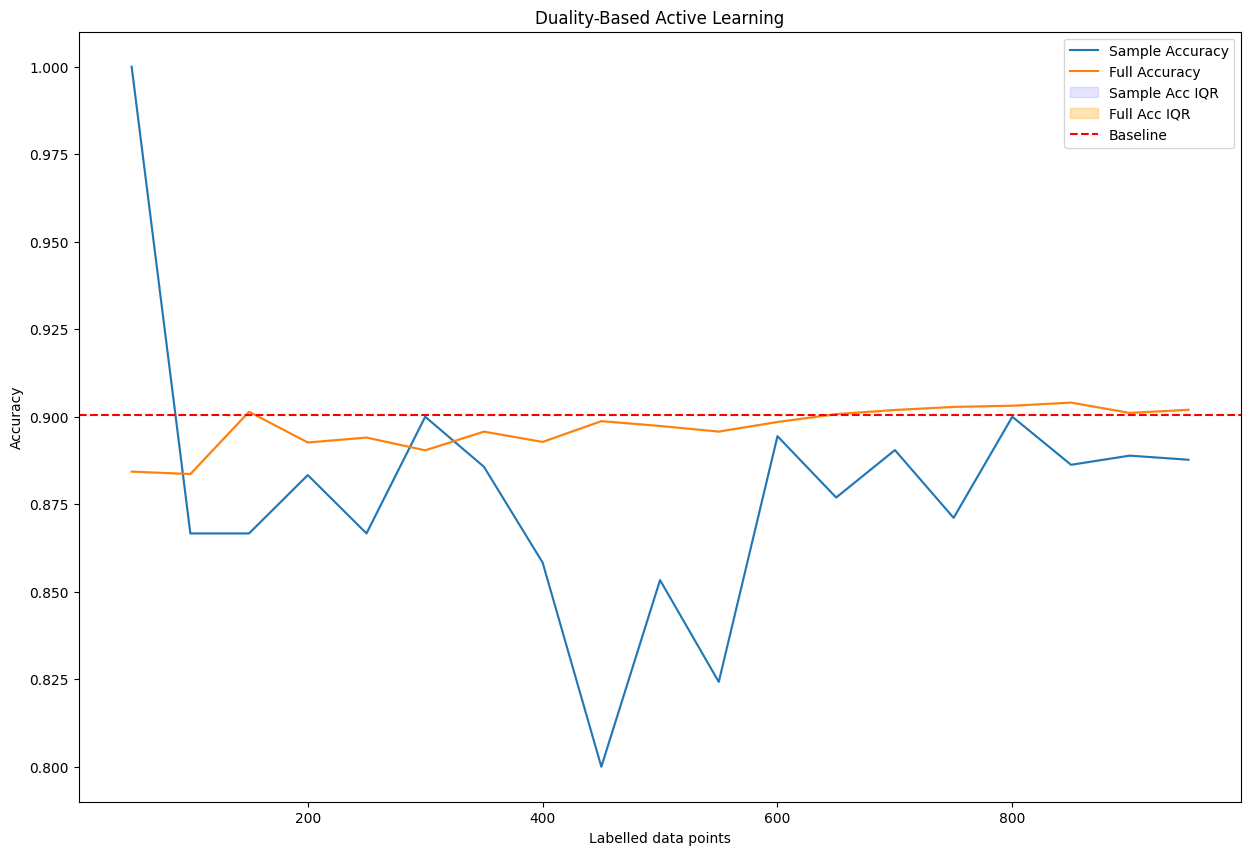

In [118]:
#### Accuracies Results
list_of_dicts = tot_accuracies_uncertainty

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
plot_result(accuracies_df, stats_sample_df, stats_full_df, baseline_accuracy, 'Duality-Based Active Learning', show_iqr_sample=True)

#### Optimization Results

In [119]:
## Build layout factor
layout_factor = pd.DataFrame.from_dict(tot_layout_factor_uncertainty[0], orient='index').reset_index()
layout_factor.columns = ['seed',f"value_{0}"]

for seed in range(1, len(tot_layout_factor_uncertainty)):
    
    df1 = pd.DataFrame.from_dict(tot_layout_factor_uncertainty[seed], orient='index').reset_index()
    df1.columns = ['seed',f"value_{seed}"]

    layout_factor = pd.merge(layout_factor, df1, on='seed')

layout_factor['average'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].mean(axis=1)
layout_factor['third_qnt'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.75, axis=1)
layout_factor['first_qnt'] = layout_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.25, axis=1)

layout_factor.drop(['value_0','value_1','value_2','value_3','value_4'], axis=1, inplace=True)

# Build objective factor
objective_factor = pd.DataFrame.from_dict(tot_objective_factor_uncertainty[0], orient='index').reset_index()
objective_factor.columns = ['seed',f"value_{0}"]

for seed in range(1, len(tot_objective_factor_uncertainty)):
    
    df1 = pd.DataFrame.from_dict(tot_objective_factor_uncertainty[seed], orient='index').reset_index()
    df1.columns = ['seed',f"value_{seed}"]

    objective_factor = pd.merge(objective_factor, df1, on='seed')

objective_factor['average'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].mean(axis=1)
objective_factor['third_qnt'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.75, axis=1)
objective_factor['first_qnt'] = objective_factor[['value_0','value_1','value_2','value_3','value_4']].quantile(0.25, axis=1)

objective_factor.drop(['value_0','value_1','value_2','value_3','value_4'], axis=1, inplace=True)


layout_factor_uncertainty = layout_factor
layout_factor_uncertainty.rename(columns={'seed':'Size'}, inplace=True)

objective_factor_uncertainty = objective_factor
objective_factor_uncertainty.rename(columns={'seed':'Size'}, inplace=True)

**Layout Factor**

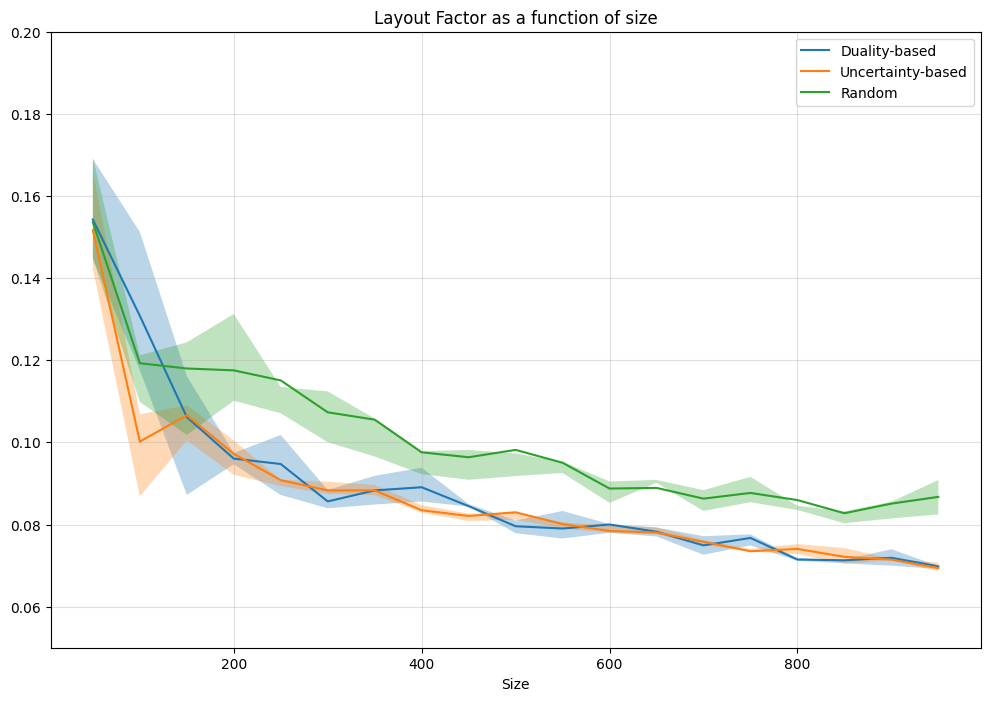

In [120]:
fig, ax = plt.subplots(figsize=(12,8))

layout_factor_duality.plot(x='Size', y='average', ax=ax, label='Duality-based')
ax.fill_between(layout_factor_duality['Size'], layout_factor_duality['first_qnt'], layout_factor_duality['third_qnt'], alpha=0.3)

layout_factor_uncertainty.plot(x='Size', y='average', ax=ax, label='Uncertainty-based')
ax.fill_between(layout_factor_uncertainty['Size'], layout_factor_uncertainty['first_qnt'], layout_factor_uncertainty['third_qnt'], alpha=0.3)

layout_factor_random.plot(x='Size', y='average', ax=ax, label='Random')
ax.fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.3)

ax.set_ylim([0.05,0.2])
plt.title('Layout Factor as a function of size')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()


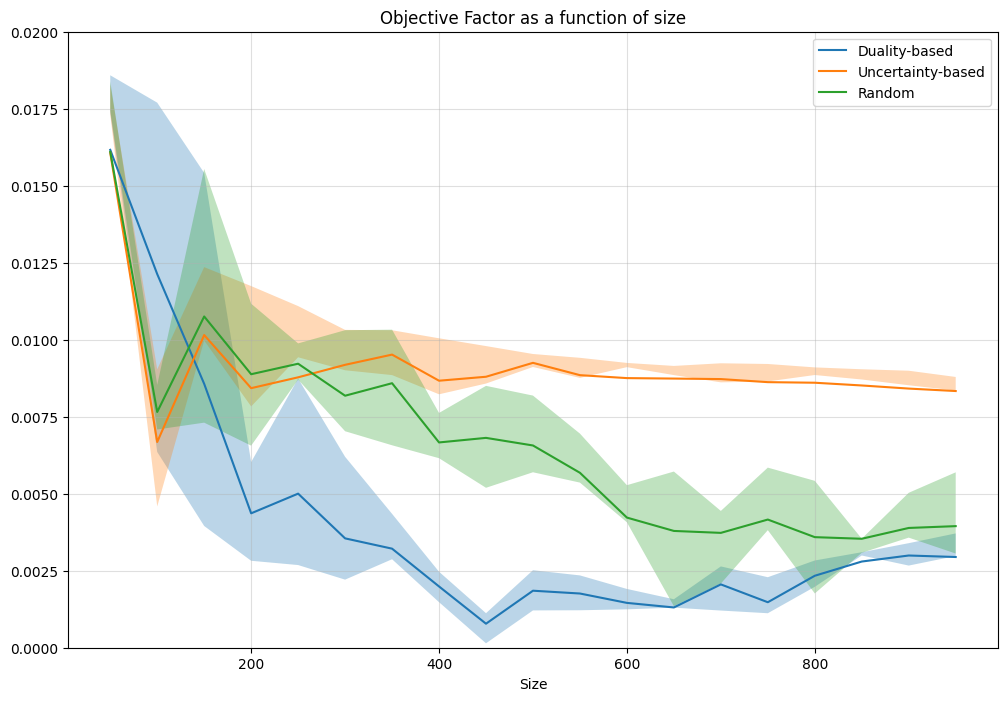

In [122]:
fig, ax = plt.subplots(figsize=(12,8))

objective_factor_duality.plot(x='Size', y='average', ax=ax, label='Duality-based')
ax.fill_between(objective_factor_duality['Size'], objective_factor_duality['first_qnt'], objective_factor_duality['third_qnt'], alpha=0.3)

objective_factor_uncertainty.plot(x='Size', y='average', ax=ax, label='Uncertainty-based')
ax.fill_between(objective_factor_uncertainty['Size'], objective_factor_uncertainty['first_qnt'], objective_factor_uncertainty['third_qnt'], alpha=0.3)

objective_factor_random.plot(x='Size', y='average', ax=ax, label='Random')
ax.fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.3)

ax.set_ylim([0,0.02])
plt.title('Objective Factor as a function of size')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()